<a href="https://colab.research.google.com/github/bobergsatoko/generativeAI/blob/main/Avanced_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Advanced GAN
# import the libraries
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm # progress bar
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show(tensor, num=25, wandbact=0, name=''):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow=5).permute(1,2,0)

  # optional - weights and biases tracking
  wandb.log({ name: wandb.Image(grid.numpy().clip(0, 1) )})

  plt.imshow(grid.clip(0, 1))
  plt.show()


# hyperparameters and general parameters
n_epochs=10000
batch_size=128
lr=0.00009
z_dim=200
device='cuda'

cur_step=0
crit_cycle=5 # 5 cycles of critic, 1 of the generator. Critic needs more training
gen_losses=[]
crit_losses=[]
show_step=35
save_step=35 # checkpoints for the NN

wandbactive = 1 # yes, we want to track stats through weights and biases, optional


In [ ]:
print(lr)

9e-05


In [ ]:
# optional: weights and biases
!pip install wandb -qqq
import wandb

wandb.login(key='dfbce035ce69eaab82c7efb37d210651583527fb')

     |████████████████████████████████| 1.9 MB 32.7 MB/s 
     |████████████████████████████████| 162 kB 69.1 MB/s 
     |████████████████████████████████| 182 kB 63.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 162 kB 71.3 MB/s 
     |████████████████████████████████| 158 kB 66.3 MB/s 
     |████████████████████████████████| 157 kB 73.2 MB/s 
     |████████████████████████████████| 157 kB 75.6 MB/s 
     |████████████████████████████████| 157 kB 25.9 MB/s 
     |████████████████████████████████| 157 kB 73.3 MB/s 
     |████████████████████████████████| 157 kB 74.3 MB/s 
     |████████████████████████████████| 157 kB 73.9 MB/s 
     |████████████████████████████████| 157 kB 71.2 MB/s 
     |████████████████████████████████| 156 kB 73.8 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%%capture
experiment_name = wandb.util.generate_id()

myrun=wandb.init(
    project='wgan',
    group=experiment_name,
    config={
        'optimizer': 'adam',
        'model': 'wgan gp',
        'epoch': '1000',
        'batch_size': 128
    }
)

config = wandb.config


In [ ]:
print(experiment_name)

1tb50lps


In [ ]:
# generator model
class Generator(nn.Module):
  def __init__(self, z_dim=200, d_dim=16):
    super(Generator, self).__init__()
    self.z_dim=z_dim

    self.gen = nn.Sequential(
      ## ConvTranspose2d: in_channels, out_channels, kernel_size, stride=1, padding = 0
      ## Calculating new width and height: (n-1) * stride - 2 * padding + ks
      ## n = width or height
      ## ks - kernel size
      ## we begin with a 1x1 image with z_dim number of channels (200)
      nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0), ## 4x4 (ch: 200, 512)
      nn.BatchNorm2d(d_dim*32),
      nn.ReLU(True),

      nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1), ## 8x8 (ch: 512, 256)
      nn.BatchNorm2d(d_dim*16),
      nn.ReLU(True),

      nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1), ## 16x16 (ch: 256, 128)
      #(n-1)*stride -2*padding +ks = (8-1)*2-2*1+4=16
      nn.BatchNorm2d(d_dim*8),
      nn.ReLU(True),

      nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1), ## 32x32 (ch: 128, 64)
      nn.BatchNorm2d(d_dim*4),
      nn.ReLU(True),            

      nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1), ## 64x64 (ch: 64, 32)
      nn.BatchNorm2d(d_dim*2),
      nn.ReLU(True),            

      nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1), ## 128x128 (ch: 32, 3)
      nn.Tanh() ### produce result in the range from -1 to 1
    )

  def forward(self, noise):
    x = noise.view(len(noise), self.z_dim, 1, 1) # 128 x 200 x 1 x 1
    return self.gen(x)

def gen_noise(num, z_dim, device='cuda'):
  return torch.randn(num, z_dim, device=device) # 128 x 200


In [ ]:
# Critic model
class Critic(nn.Module):
  def __init__(self, d_dim=16):
    super(Critic, self).__init__()

    self.critic = nn.Sequential(
      # Conv2d: in_channels, out_channels, kernel_size, stride=1, padding=0
      # New width and height: (n+2*pad-ks)//stride + 1
      ## the input is the image 128 x 128
      nn.Conv2d(3, d_dim, 4, 2, 1), # (128+2*1-4)//2+1 = 64x64 (ch: 3, 16)
      nn.InstanceNorm2d(d_dim), # Instance norm works better
      nn.LeakyReLU(0.2), # solves dying ReLU (if all are 0 you stop gradient)

      nn.Conv2d(d_dim, d_dim*2, 4, 2, 1), # 32x32 (ch: 16, 32)
      nn.InstanceNorm2d(d_dim*2),
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1), # 16x16 (ch: 32, 64)
      nn.InstanceNorm2d(d_dim*4),
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1), # 8x8 (ch: 64, 128)
      nn.InstanceNorm2d(d_dim*8),
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1), # 8x8 (ch: 128, 256)
      nn.InstanceNorm2d(d_dim*16),
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*16, 1, 4, 1, 0), # (4+2*0-4)//1+1 = 1 (ch: 256, 1)
    )

  def forward(self, image):
    # image: 128 x 3 x 128 x 128 (batch, rgb, 128, 128)
    crit_pred = self.critic(image) # 128 x 1 x 1 x 1
    return crit_pred.view(len(crit_pred), -1) # 128 x 1

In [ ]:
# optional, init your weights in different ways
def init_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02) # in place change
    torch.nn.init.constant_(m.bias, 0)

  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02) # in place change
    torch.nn.init.constant_(m.bias, 0)

In [ ]:
# load dataset
import gdown, zipfile

url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&export=download'
path = 'drive/MyDrive/img_align_celeba.zip'
toPath = 'data/celeba'
#download_path=f'{path}/img_align_celeba.zip'

if not os.path.exists(path):
  os.makedirs(path)

#gdown.download(url, download_path, quiet=False)

with zipfile.ZipFile(path, 'r') as ziphandler:
  ziphandler.extractall(toPath)

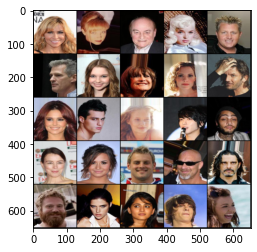

In [ ]:
# Dataset, Dataloader, declare gen, crit, test dataset

class Dataset(Dataset):
  def __init__(self, path, size=128, lim=10000):
    self.sizes=[size, size]
    items, labels = [],[]

    for data in os.listdir(path)[:lim]:
      # path: './data/celeba/img_align_celeba'
      # data: '114568.jpg'
      item = os.path.join(path, data)
      items.append(item)
      labels.append(data)

    self.items=items
    self.labels=labels

  def __len__(self):
    return len(self.items)
  
  def __getitem__(self, idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB') # ( 178, 218 - original size)
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # 128 x 128 x 3
    # in torch we want the opposite order channel, size, size
    data = np.transpose(data, (2, 0, 1)).astype(np.float32, copy=False) # 3 x 128 x 128 - values go from 0 to 255
    data = torch.from_numpy(data).div(255) # we normalize

    return data, self.labels[idx]

# we instantiate Dataset
data_path = './data/celeba/img_align_celeba'
ds = Dataset(data_path, size = 128, lim=10000)

## data loader
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

## instantiate Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

# optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.4, 0.85)) # betas - used internally for momentum and other calculations
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.4, 0.85))

# gen = gen.apply(init_weights) - to apply it / otherweights 
# crit = crit.apply(init_weights)

# wandb optional
if (wandbactive==1):
  wandb.watch(gen, log_freq=100)
  wandb.watch(crit, log_freq=100)

x, y = next(iter(dataloader)) # give me a batch
show(x)

In [ ]:
# gradient penalty calculation
def get_gp(real, fake, crit, alpha, gamma=20):
  mix_images = real * alpha + fake * (1-alpha) # 128 x 3 x 128 x 128 - linear interpolation
  mix_scores = crit(mix_images) # 128 x 1

  gradient = torch.autograd.grad( # calculates the sum of the gradient of the outputs with respects to the inputs
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs=torch.ones_like(mix_scores),
      retain_graph=True,
      create_graph=True
  )[0] # 128 x 3 x 128 x 128

  gradient = gradient.view(len(gradient), -1) # 128 x 49152
  gradient_norm = gradient.norm(2, dim=1)
  gp = gamma * ((gradient_norm - 1)**2).mean()

  return gp

In [ ]:
## save and load check points

root_path = './drive/MyDrive/'

def save_checkpoint(name):
  torch.save({
      'epoch': epoch,
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict()
  }, f"{root_path}G-{name}.pkl")

  torch.save({
      'epoch': epoch,
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()
  }, f"{root_path}C-{name}.pkl")

  print('Saved checkpoint')

def load_checkpoint(name):
  checkpoint = torch.load(f"{root_path}G-{name}.pkl")
  gen.load_state_dict(checkpoint['model_state_dict'])
  gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f"{root_path}C-{name}.pkl")
  crit.load_state_dict(checkpoint['model_state_dict'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
epoch = 1
load_checkpoint('latest');

In [ ]:
# Training loop
for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_bs = len(real) # 128
    real = real.to(device)

    ## Critic
    mean_crit_loss = 0
    for _ in range(crit_cycle):
      crit_opt.zero_grad()

      noise = gen_noise(cur_bs, z_dim)
      fake = gen(noise)
      crit_fake_pred = crit(fake.detach()) # we don't update the params of the gen
      crit_real_pred = crit(real)

      # gradient penalty
      alpha = torch.rand(len(real), 1, 1, 1, device = device, requires_grad=True); # 128 x 1 x 1 x 1
      gp = get_gp(real, fake.detach(), crit, alpha)

      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

      mean_crit_loss += crit_loss.item() / crit_cycle

      crit_loss.backward(retain_graph=True)
      crit_opt.step()

    crit_losses +=[mean_crit_loss]

    # generator
    gen_opt.zero_grad()
    noise = gen_noise(cur_bs, z_dim)
    fake = gen(noise)
    crit_fake_pred = crit(fake)

    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()

    gen_losses += [gen_loss.item()]

    ## stats
    if (wandbactive):
      wandb.log({'Epoch': epoch, 'Step': cur_step, 'Critic loss': mean_crit_loss, 'Gen loss': gen_loss})
    
    if cur_step % save_step and cur_step > 0:
      print('Saving checkpoint', cur_step, save_step)
      save_checkpoint("latest3")

    if (cur_step % show_step == 0 and cur_step > 0):
      show(fake, wandbact=1, name = 'fake')
      show(real, wandbact=1, name = 'real')

      gen_mean = sum(gen_losses[-show_step:]) / show_step
      crit_mean = sum(crit_losses[-show_step:]) / show_step
      print(f"Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean}, critic_loss: {crit_mean}")

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(gen_losses),
          label='Generator loss'
      )

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(crit_losses),
          label='Critic loss'
      )

      plt.ylim(-1000, 1000)
      plt.legend()
      plt.show()

    cur_step += 1

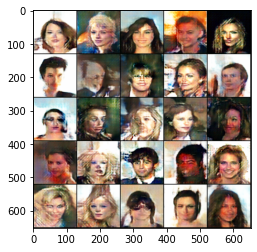

In [ ]:
### Generate new faces
noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

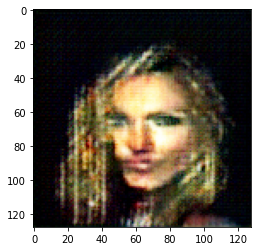

In [ ]:
plt.imshow(fake[4].detach().cpu().permute(1, 2, 0).squeeze().clip(0, 1)) # the number of channels between pytorch and matplotlib are different

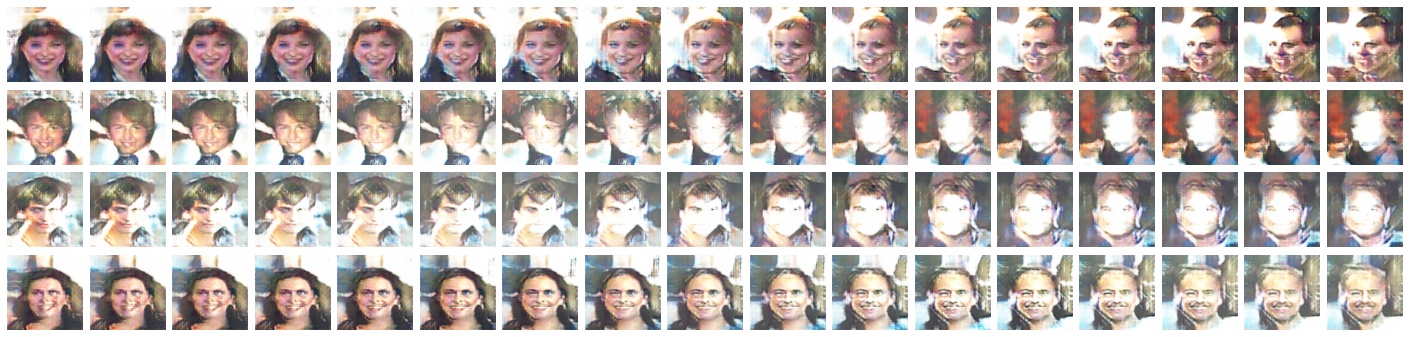

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

# morphing, interpolation between points in latent space
gen_set=[]
z_shape = [1,200, 1, 1]
rows=4
steps=17

for i in range(rows):
  z1,z2 = torch.randn(z_shape), torch.randn(z_shape)
  for alpha in np.linspace(0, 1, steps):
    z = alpha * z1 + (1 - alpha) * z2;
    res = gen(z.cuda())[0]
    gen_set.append(res)

fig = plt.figure(figsize=(25, 11))
grid = ImageGrid(fig, 111, nrows_ncols=(rows, steps), axes_pad=0.1)

for ax, img in zip(grid, gen_set):
  ax.axis('off')
  res = img.cpu().detach().permute(1, 2, 0)
  res = res - res.min()
  res = res/(res.max() - res.min())
  ax.imshow(res);

plt.show();